In [ ]:
# to_save, to_load = False, True
# session_file = "./tmp/TIC_417436377_EA_contaminated_by_TIC_417436387.pkl"

# # load/save the notebook session
# # https://dill.readthedocs.io/en/latest/
# if True: 
#     import dill
#     dill.load_module(session_file)
#     print(f"Notebook session loaded from  {session_file}")

# if True:  # save the notebook session
#     import dill
#     dill.dump_module(session_file)
#     print(f"Notebook session saved in {session_file}")


In [1]:
import sys
if "../" not in sys.path:  # to get my usual helpers at base dir
    sys.path.append("../")

import lightkurve as lk
from lightkurve_ext import of_sector, of_sectors, of_2min_cadences
import lightkurve_ext as lke
from lightkurve_ext import TransitTimeSpec, TransitTimeSpecList
import lightkurve_ext_tess as lket
import lightkurve_ext_pg as lke_pg
import lightkurve_ext_pg_runner as lke_pg_runner
import tic_plot as tplt

import asyncio_compat

import math
import re
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib

import pandas as pd
import astropy as astropy
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time, TimeDelta
from astropy.io import fits

from matplotlib.ticker import (FormatStrFormatter, AutoMinorLocator)

from importlib import reload # useful during development to reload packages

from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7


# No longer works in Jupyter 7+
display(Javascript("""
// export notebook url to Python for bokeh-based interactive features
if (window["IPython"] != null) {
  IPython.notebook.kernel.execute(`notebook_url = "${window.location.origin}"`);
} else {
  console.warn("IPython js object not available (in Jupyter 7). Hardcode notebook_url in the notebook itself instead.")
}
"""));
notebook_url = "localhost:8888"

%matplotlib inline

# data cache config
lk_download_dir = '../data'
if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir

# make markdown table aligned to the left of the cell output (instead of center)
display(HTML("<style>table {margin-left: 4ch;}</style>"))

<IPython.core.display.Javascript object>

# TIC 38125059 / Gaia DR3 5650153795719308672  Analysis (EA)

- some uncertainty in ID, the source might be nearby TIC 830918261
- new VSX entry
- known quadruple system
  - https://www.ctio.noirlab.edu/~atokovin/stars/stars.php?cat=HIP&number=44874 
  - https://vizier.cds.unistra.fr/viz-bin/VizieR-6?-source=J/ApJS/235/6/%2a&ID=09086-2550


## TESS Data

In [2]:
tic = 38125059

sr = lk.search_lightcurve(f"TIC{tic}", )  # author="SPOC", cadence="short"
sr_unfiltered = sr  # keep a copy
sr = lke.filter_by_priority(sr, author_priority = ["SPOC", "TESS-SPOC", "QLP"])
# sr = sr[sr.author == "QLP"]  # for uniformity, only 1 sector (3) has no QLP data
# sr = lke._sort_chronologically(sr)

astropy.table.pprint.conf.max_lines = 100  # to print all rows
display(sr)

# Note: only 1 sector of ready made lightcurve
# if needed, lightcurves can be created from sectors 37, 63, 64 (and in the future 90, 99, 100, 101)
lcc_tess = sr.download_all()
lcc_tess

#,mission,year,author,exptime,target_name,distance,proposal_id
,,,,s,,arcsec,
0,TESS Sector 08,2019,SPOC,120,38125059,0.0,"G011048 , G011250"
1,TESS Sector 35,2021,SPOC,120,38125059,0.0,"G03227 , G03251"
2,TESS Sector 62,2023,SPOC,120,38125059,0.0,"G05155 , G05003"
3,TESS Sector 89,2025,SPOC,120,38125059,0.0,N/A


LightCurveCollection of 4 objects:
    0: <TessLightCurve LABEL="TIC 38125059" SECTOR=8 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 38125059" SECTOR=35 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    2: <TessLightCurve LABEL="TIC 38125059" SECTOR=62 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    3: <TessLightCurve LABEL="TIC 38125059" SECTOR=89 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>

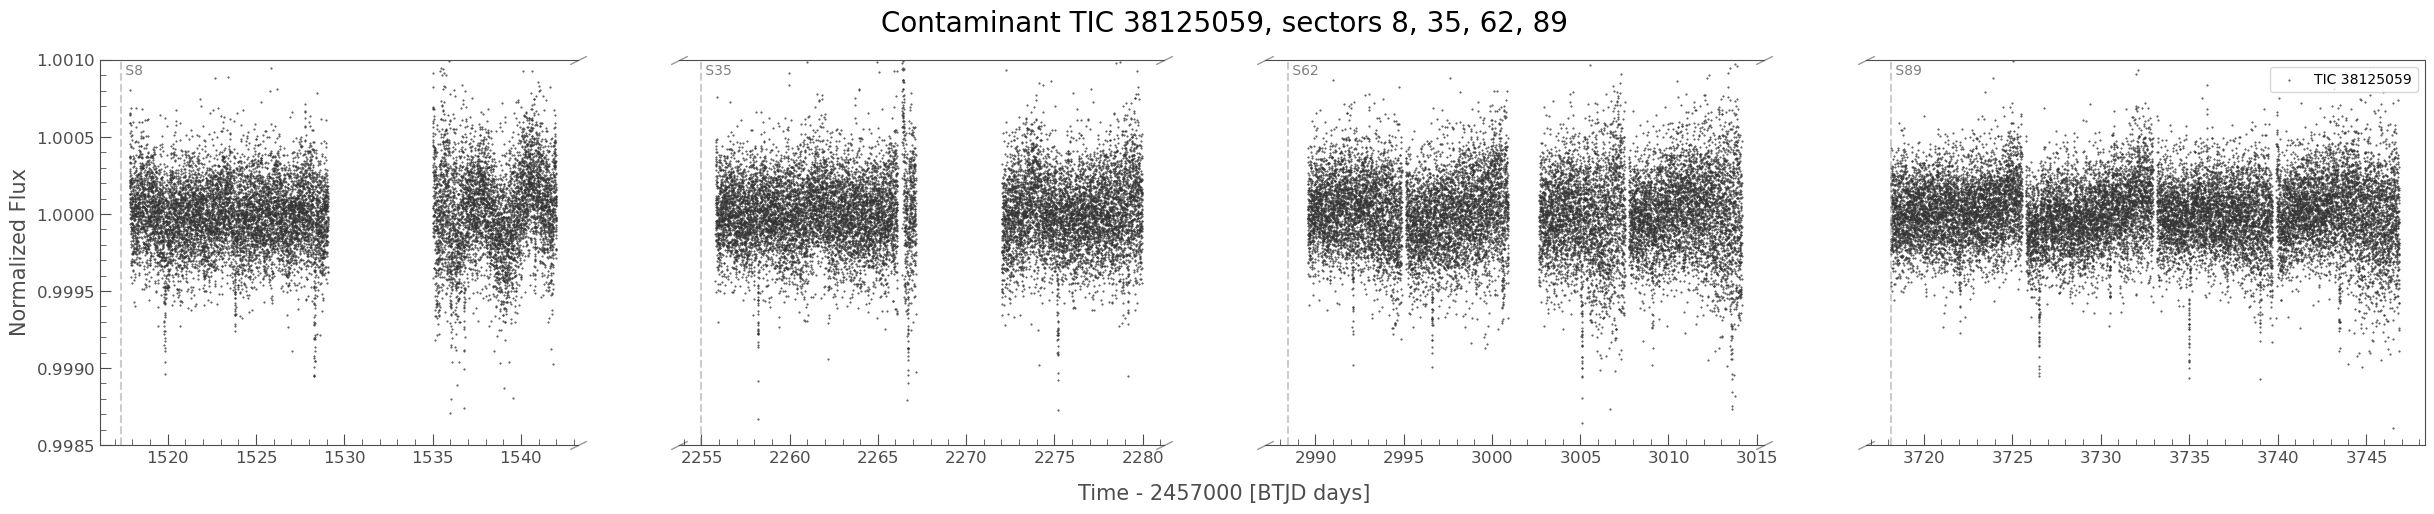

In [4]:
lc = lke.stitch(lcc_tess, ignore_incompatible_column_warning=True,)

axs = tplt.plot_skip_data_gap(lc, figsize=(30,5), s=1, alpha=0.9);
axs[0].get_figure().suptitle(f"Contaminant {lc.label}, sectors {lke.abbrev_sector_list(lc)}", fontsize=20);
[ax.set_ylim(0.9985, 1.001) for ax in axs];

### Identification Uncertainty


Centroid from [TCE](https://exo.mast.stsci.edu/exomast_planet.html?planet=TIC38125059S0001S0065TCE1):

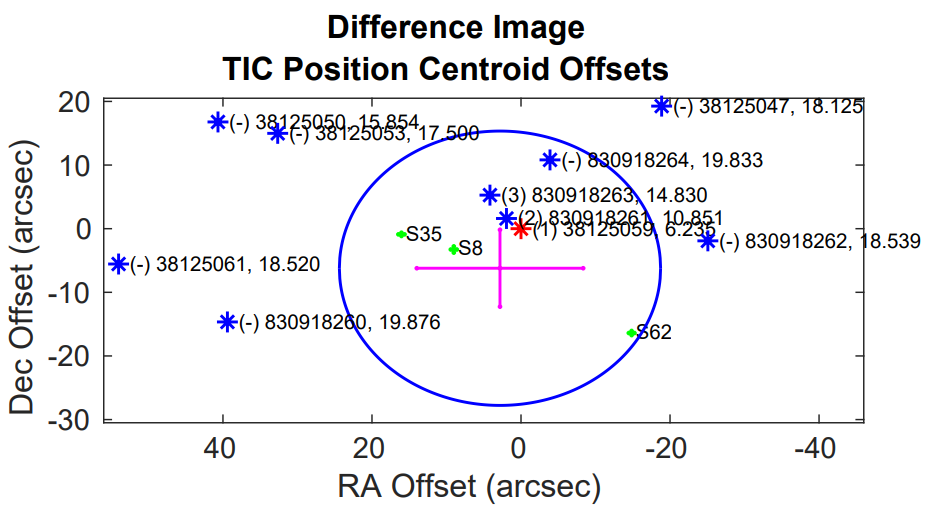

- the nearby TIC 830918261 is a possibility
- TIC 830918263, a bit farther away, is too faint to be the source
- inconclsuive result with alternartive methods. See https://www.zooniverse.org/projects/nora-dot-eisner/planet-hunters-tess/talk/6723/3655335?comment=6002605


## Gaia DR3 info (coordinate, etc.)

In [156]:
# reload(lke)
# reload (lket)
rs_all_cols, rs, rs_html  = lket.search_gaiadr3_of_tics(tic, radius_arcsec=20, magnitude_range=None,  pm_error_factor=None, pm_range_fraction=None, pm_range_minimum=None, 
                                                        calc_separation_from_first_row=True,  # assuming the first row is the target, it'd calculate more accurately the separation for Gaia DR3 Main
                                                        compact_columns=True, also_return_html=True, also_return_astrophysical=False, verbose_html=True, include_nss_summary_in_html=False)
display(HTML(rs_html))

# from Gaia DR3
target_coord = SkyCoord(rs[0]["RAJ2000"], rs[0]["DEJ2000"], unit=(u.deg, u.deg), frame="icrs")
target_coord_dict = dict(ra=target_coord.ra.value, dec=target_coord.dec.value)


C:\dev\_juypter\PH_TESS_LightCurveViewer\targets\..\lightkurve_ext.py:1936: UserWarning: gaia_dr3_mag_to_vmag(): b_minus_r value (--) is outside the applicable range for the transformation. The result is probably not reliable.
  warnings.warn(


The target is also listed as an astrometric binary with 177.74 d (+/- 1.33 d) period in [Gaia DR3 NSS](https://vizier.cds.unistra.fr/viz-bin/VizieR-4?-ref=VIZ65a1a2351812e4&-source=I%2F357&Source=5483610730803645312)


In [7]:
primary_name = f"TIC {tic}"  # Use TIC (instead of better known HD, HIP< etc.) as the EA variability is seen in TESS data only
primary_name

'TIC 38125059'

## Combining all data

- Archival ASAS3 data exists, but it does not have the photometric precison needed: 
https://www.astrouw.edu.pl/cgi-asas/asas_variable/090837-2550.4,asas3,0,0,500,0,0


TESS # data points: 65800


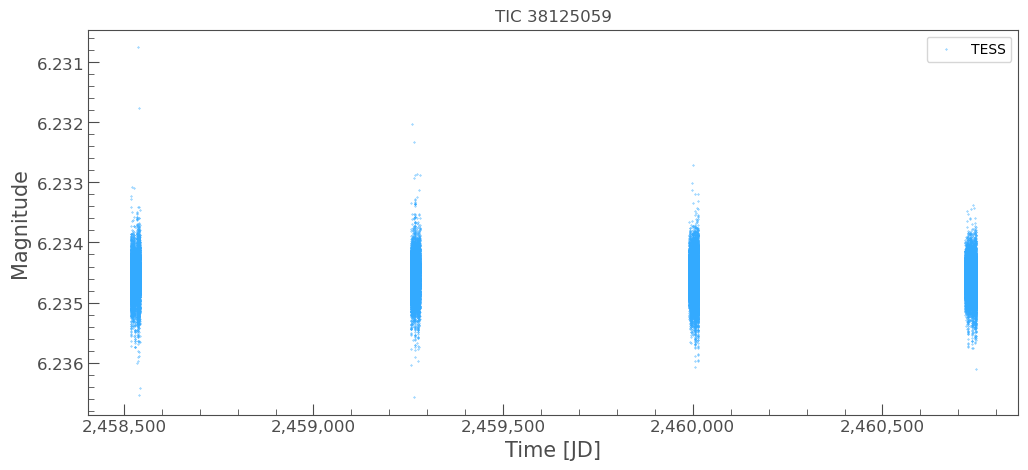

In [73]:
# Convert the data to magnitude and HJD/UTC

import lightkurve_ext_multi_sources as lkem
# reload(lkem)

lc_tess = lke.stitch(lcc_tess, ignore_incompatible_column_warning=True)
lc_tess = lke.to_flux_in_mag_by_normalization(lc_tess)
lc_tess = lke.convert_lc_time_to_hjd_utc(lc_tess, target_coord=target_coord, cache_dir=lk_download_dir)

# axs = tplt.plot_skip_data_gap(lc_tess, figsize=(30,5), s=4, alpha=0.9);

lc_combined_dict = lkem.combine_multi_bands_and_shift(
    {"TESS": lc_tess, 
    }, 
    shift_to=None,
)

for k in lc_combined_dict.keys():
    print(f"{k} # data points:", len(lc_combined_dict[k]))

plot_options = lkem.get_default_plot_multi_bands_options_copy()
# for TESS plot (index 0) move it to the front
# plot_options[0][1]["zorder"] = 3  # default 2

ax = lkem.plot_multi_bands(lc_combined_dict, figsize=(12, 5), target_name=primary_name, plot_options=plot_options);
# ax.set_ylim(15.2, 14.0);

## Final epoch / period / duration

- epoch / period / duration determined from MCMC model in the separate ETV analsysis (null result)

Adopted period / epoch / duration_hr:  8.4873 2458519.815 1.8 1.8
Min II phase: 0.47


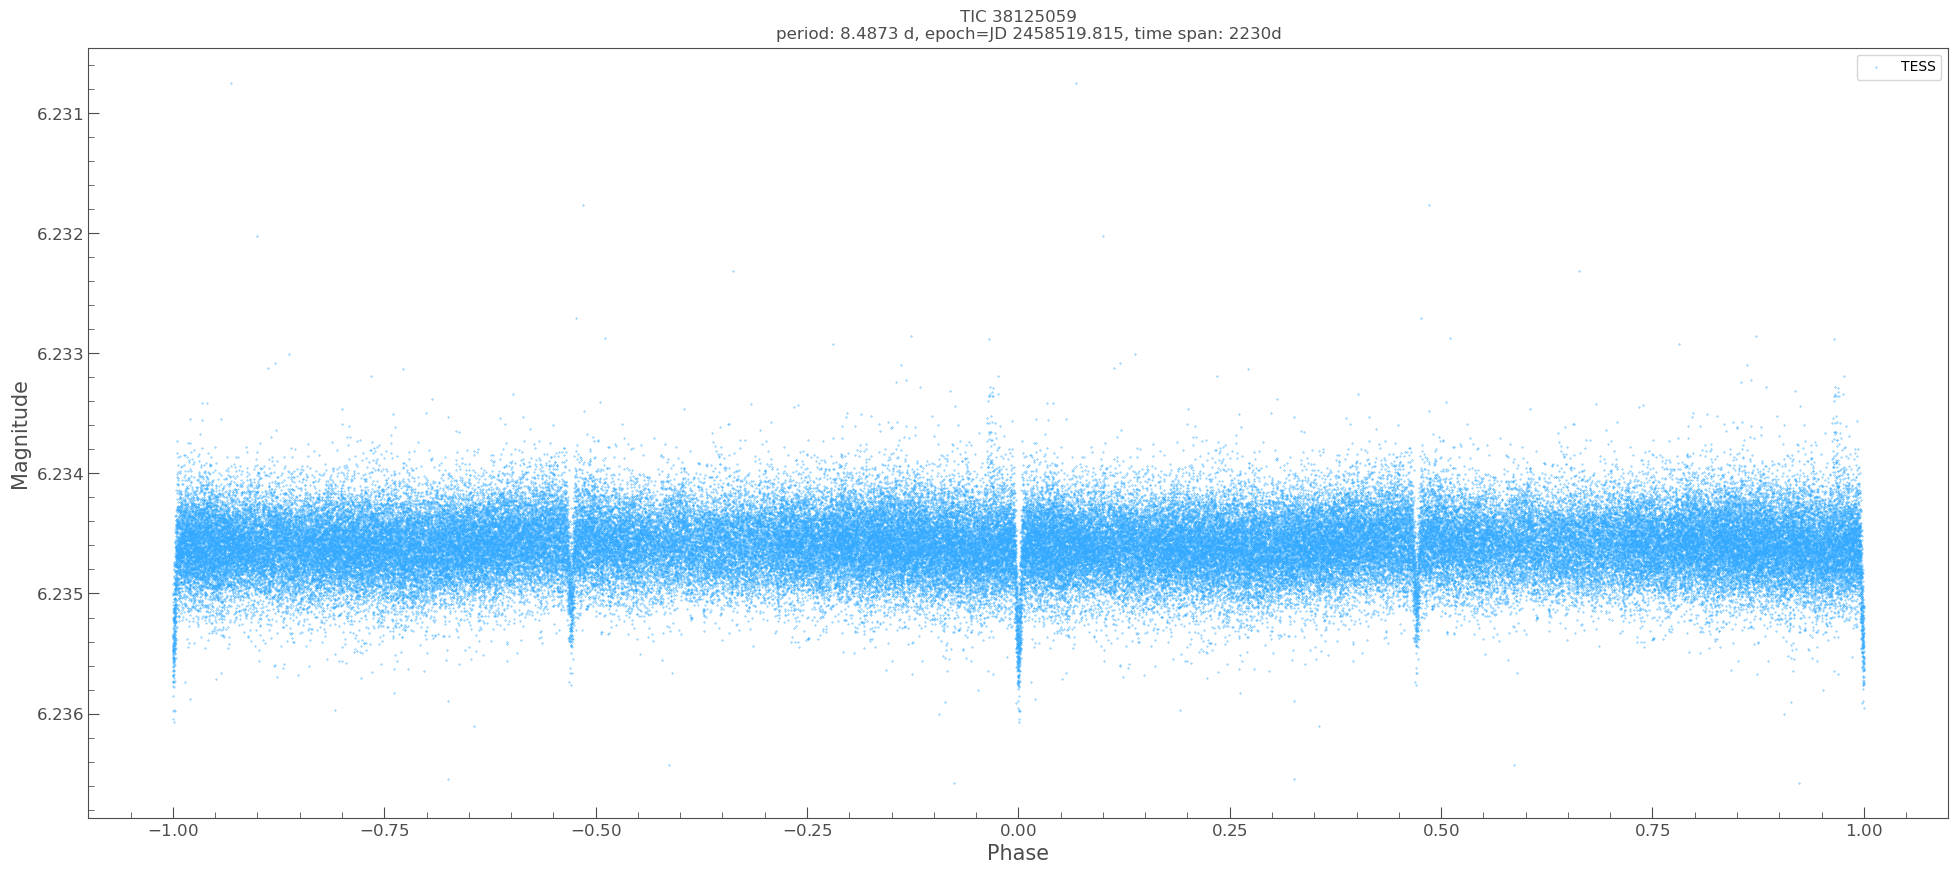

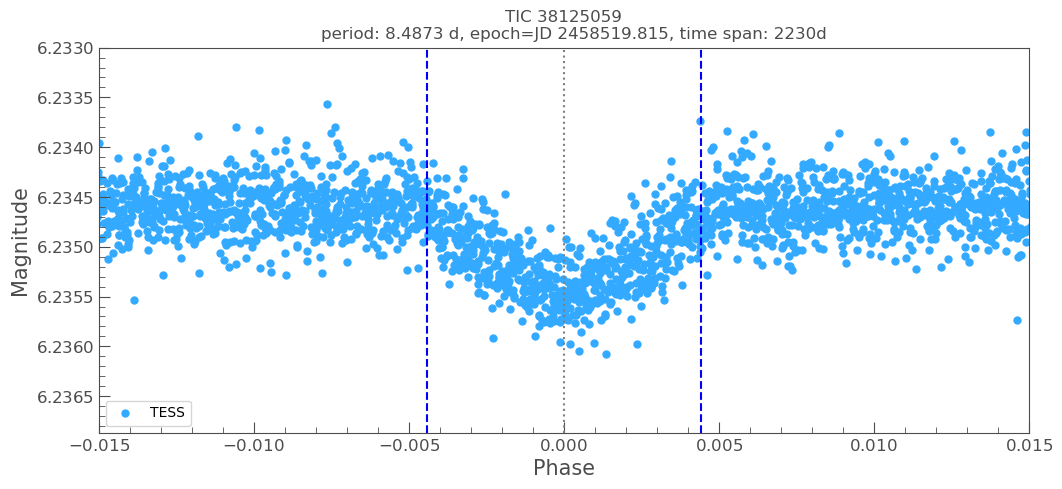

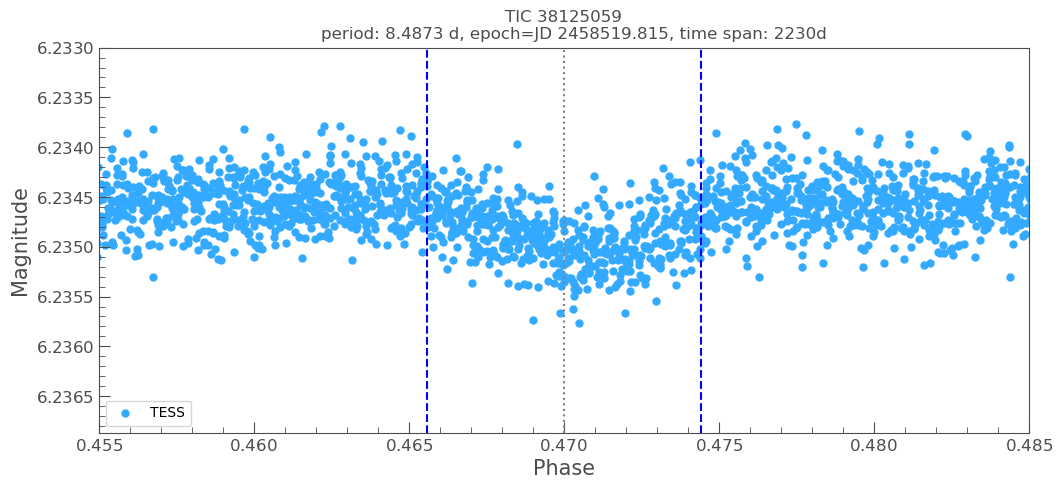

In [136]:
# Cannot tell the difference between TCE period and BLS period, cut 1 digit and choose the best
period_final = 8.48730
epoch_time_btjd_final = 1519.816
epoch_time_hjd_final = round(lket.btjd_to_hjd_utc(epoch_time_btjd_final, target_coord), 3)  # need 3 digit to ensure it does look off visually
epoch_time_min_ii_btjd_final = 1523.80 + 0.01   # manual adjustment after inspecting Min II zoom 
epoch_time_min_ii_hjd_final = round(lket.btjd_to_hjd_utc(epoch_time_min_ii_btjd_final, target_coord), 3) 

duration_hr_min_i_final = 1.8
duration_hr_min_ii_final = 1.8

# Note: slightly eccentric
epoch_phase_min_ii_final   = abs(epoch_time_min_ii_btjd_final   - epoch_time_btjd_final  ) / period_final   % 1
if epoch_phase_min_ii_final   > 0.5:
    epoch_phase_min_ii_final   = epoch_phase_min_ii_final   - 1
epoch_phase_min_ii_final   = round(epoch_phase_min_ii_final  , 2)  # precsion from eyeballing zoomed plot

print("Adopted period / epoch / duration_hr: ", period_final, epoch_time_hjd_final, duration_hr_min_i_final, duration_hr_min_ii_final)
print("Min II phase:", epoch_phase_min_ii_final)

# --- Plot them to verify ---

ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_final,
    epoch=Time(epoch_time_hjd_final   , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
    figsize=(24, 10),
    target_name=primary_name,
    # plot_options=plot_options,
);


# zoom plot Min I
# - make TESS more visible:  larger dots
plot_options_zoom = lkem.get_default_plot_multi_bands_options_copy()
plot_options_zoom[0][1]["s"] = 25
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_final  ,
    epoch=Time(epoch_time_hjd_final   , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    duration_hr=duration_hr_min_i_final  ,  # for plotting only
    figsize=(12, 5),
    plot_options=plot_options_zoom,
    # mag_shift_precision=2,  #
);
ylim = (None, 6.233)
ax.set_ylim(*ylim);
ax.legend(loc="lower left");
ax.axvline(0, c="gray", linestyle="dotted");
ax.set_xlim(-0.015, 0.015);  # to see primary in details


# zoom plot - Min II
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_final  ,
    epoch=Time(epoch_time_hjd_final   , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    duration_hr=duration_hr_min_ii_final  ,  # for plotting only
    duration_midpoint_phase=epoch_phase_min_ii_final  ,
    plot_options=plot_options_zoom,
    figsize=(12, 5),
    # mag_shift_precision=2,  #
);
ax.set_ylim(*ylim);
ax.legend(loc="lower left");
ax.axvline(epoch_phase_min_ii_final, c="gray", linestyle="dotted");
ax.set_xlim(epoch_phase_min_ii_final  -0.015, epoch_phase_min_ii_final  +0.015);  # to see Min II in details


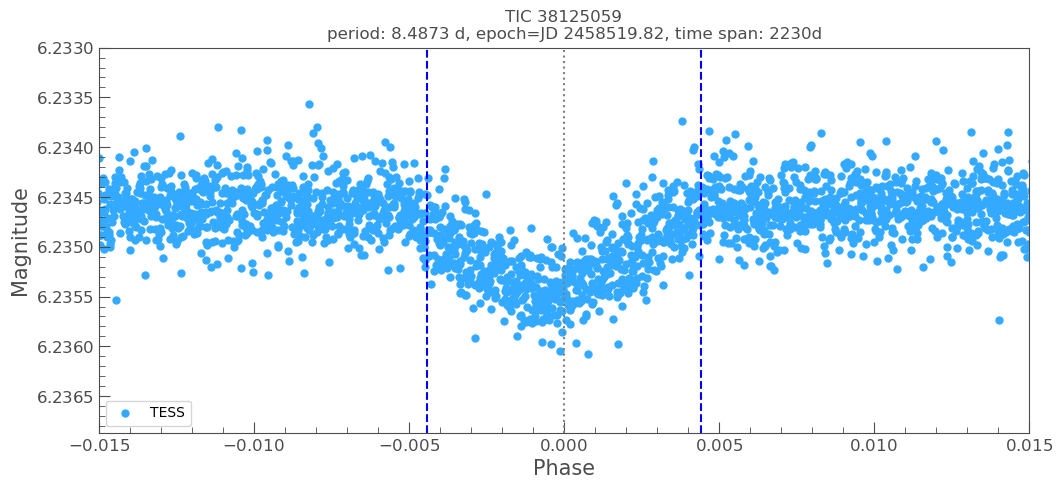

In [157]:
# demonstrate the differnce if Min I epoch is in 2 digits instead of 3 digits

_et = round(epoch_time_hjd_final, 2)
# zoom plot Min I
# - make TESS more visible:  larger dots
plot_options_zoom = lkem.get_default_plot_multi_bands_options_copy()
plot_options_zoom[0][1]["s"] = 25
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_final  ,
    epoch=Time(_et  , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    duration_hr=duration_hr_min_i_final  ,  # for plotting only
    figsize=(12, 5),
    plot_options=plot_options_zoom,
    # mag_shift_precision=2,  #
);
ylim = (None, 6.233)
ax.set_ylim(*ylim);
ax.legend(loc="lower left");
ax.axvline(0, c="gray", linestyle="dotted");
ax.set_xlim(-0.015, 0.015);  # to see primary in details


## Determine Magnitude Range


Min I mag # num data points: 60
Min II mag # num data points: 50
['6.2346', '6.2355', '6.2351']


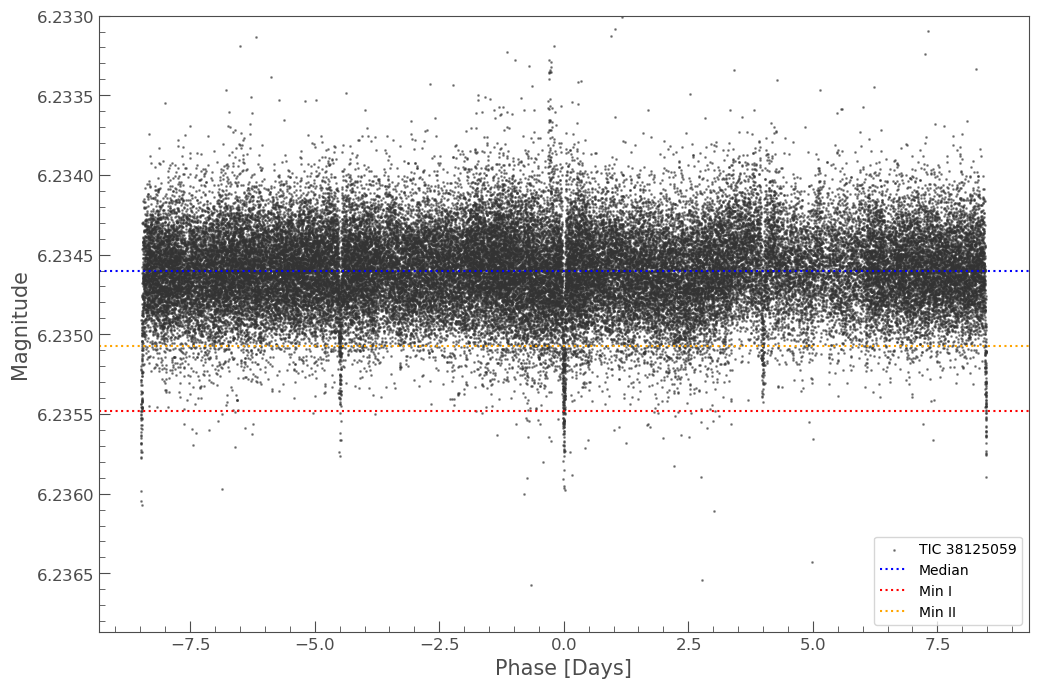

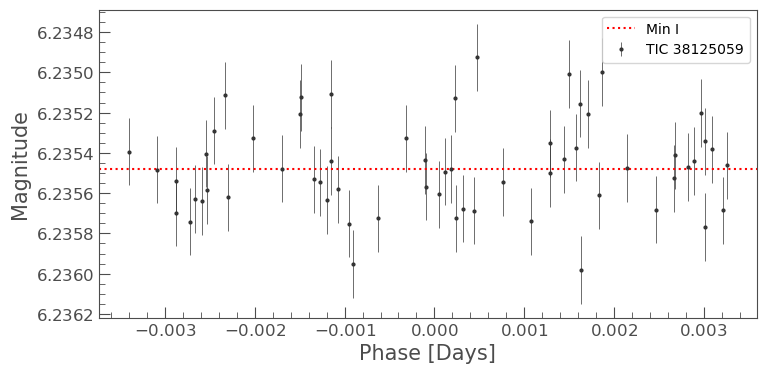

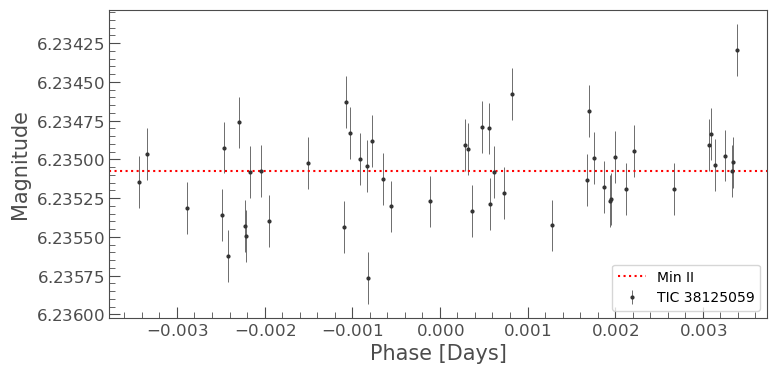

In [148]:
# %matplotlib widget
%matplotlib inline

# From TESS data (shifted back to TESS mag)

lc = lc_combined_dict["TESS"]
# max_flux_mag = lc.flux.min().value  #
# min_flux_mag = lc.flux.max().value
median_flux_mag = np.nanmedian(lc.flux.value)

lc_zoom_min = lc.fold(epoch_time=epoch_time_hjd_final, period=period_final).truncate(0 - 5 /24/60, 0 + 5 /24/ 60)
print("Min I mag # num data points:", len(lc_zoom_min))
min_flux_mag = np.nanmedian(lc_zoom_min.flux.value)

lc_zoom_min_ii = lc.fold(epoch_time=epoch_time_min_ii_hjd_final, period=period_final).truncate(0 - 5 /24/60, 0 + 5 /24/ 60)
print("Min II mag # num data points:", len(lc_zoom_min_ii))
min_ii_flux_mag = np.nanmedian(lc_zoom_min_ii.flux.value)


lc_f = lc.fold(epoch_time=epoch_time_hjd_final, period=period_final * 2)  # 2x period plot
ax = tplt.lk_ax(figsize=(12, 8))
ax = tplt.scatter(lc_f, ax=ax, alpha=0.5);
ax.axhline(median_flux_mag, c="blue", linestyle="dotted", label="Median")
ax.axhline(min_flux_mag, c="red", linestyle="dotted", label="Min I")
ax.axhline(min_ii_flux_mag, c="orange", linestyle="dotted", label="Min II")
ax.legend(loc="lower right");
# ax.set_xlim(-0.5, 0.5); 
ax.set_ylim(*ylim);

ax = tplt.errorbar(lc_zoom_min, marker="o");
ax.axhline(min_flux_mag, c="red", linestyle="dotted", label="Min I")
# ax.set_ylim(*ylim);
ax.legend();

ax = tplt.errorbar(lc_zoom_min_ii, marker="o");
ax.axhline(min_ii_flux_mag, c="red", linestyle="dotted", label="Min II")
ax.legend(loc="lower right");

print([f"{v:.4f}" for v in [median_flux_mag, min_flux_mag, min_ii_flux_mag]])



In [149]:
# TESS only data, to report mean V mag and ampitude in TESS
mean_flux_v_mag = np.round(rs_all_cols["Vmag"][0], 2)  # V converted from Gaia DR3 

amp_flux_mag = np.round(np.abs(float(min_flux_mag - median_flux_mag)) , 3)  # in TESS band, 4 digit would be more accurate but it's below VSX threshold of 0.001

amp_min_ii_flux_mag = np.round(np.abs(float(min_ii_flux_mag - median_flux_mag)) , 4)  # in TESS band, 4 digit needed as it's below VSX thresholkd of 0.001

(mean_flux_v_mag, amp_flux_mag, amp_min_ii_flux_mag)

(6.77, 0.001, 0.0005)

## Plots for VSX

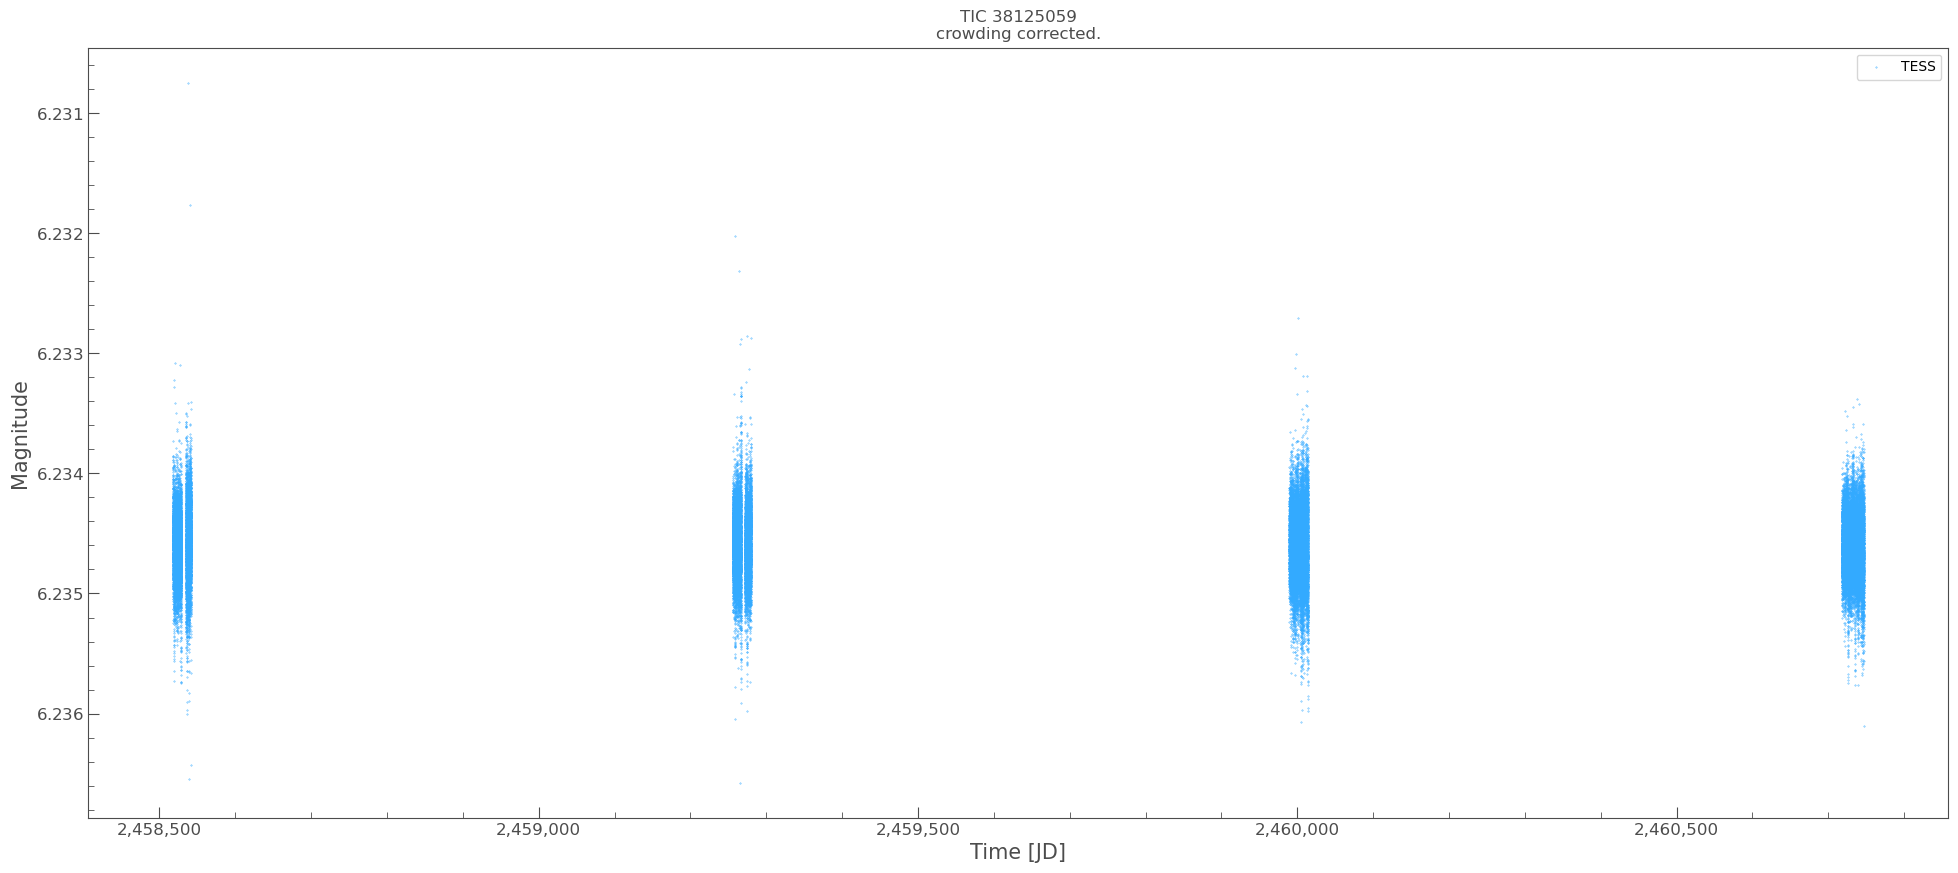

In [43]:
# reload(lkem)
# Not needed
plot_options = lkem.get_default_plot_multi_bands_options_copy()
# plot_options[0][1]["zorder"] = 4

ax = lkem.plot_multi_bands(lc_combined_dict, figsize=(24, 10), target_name=primary_name, plot_options=plot_options);
ax.set_title(ax.get_title() + "\ncrowding corrected.");

#### Phase Plot



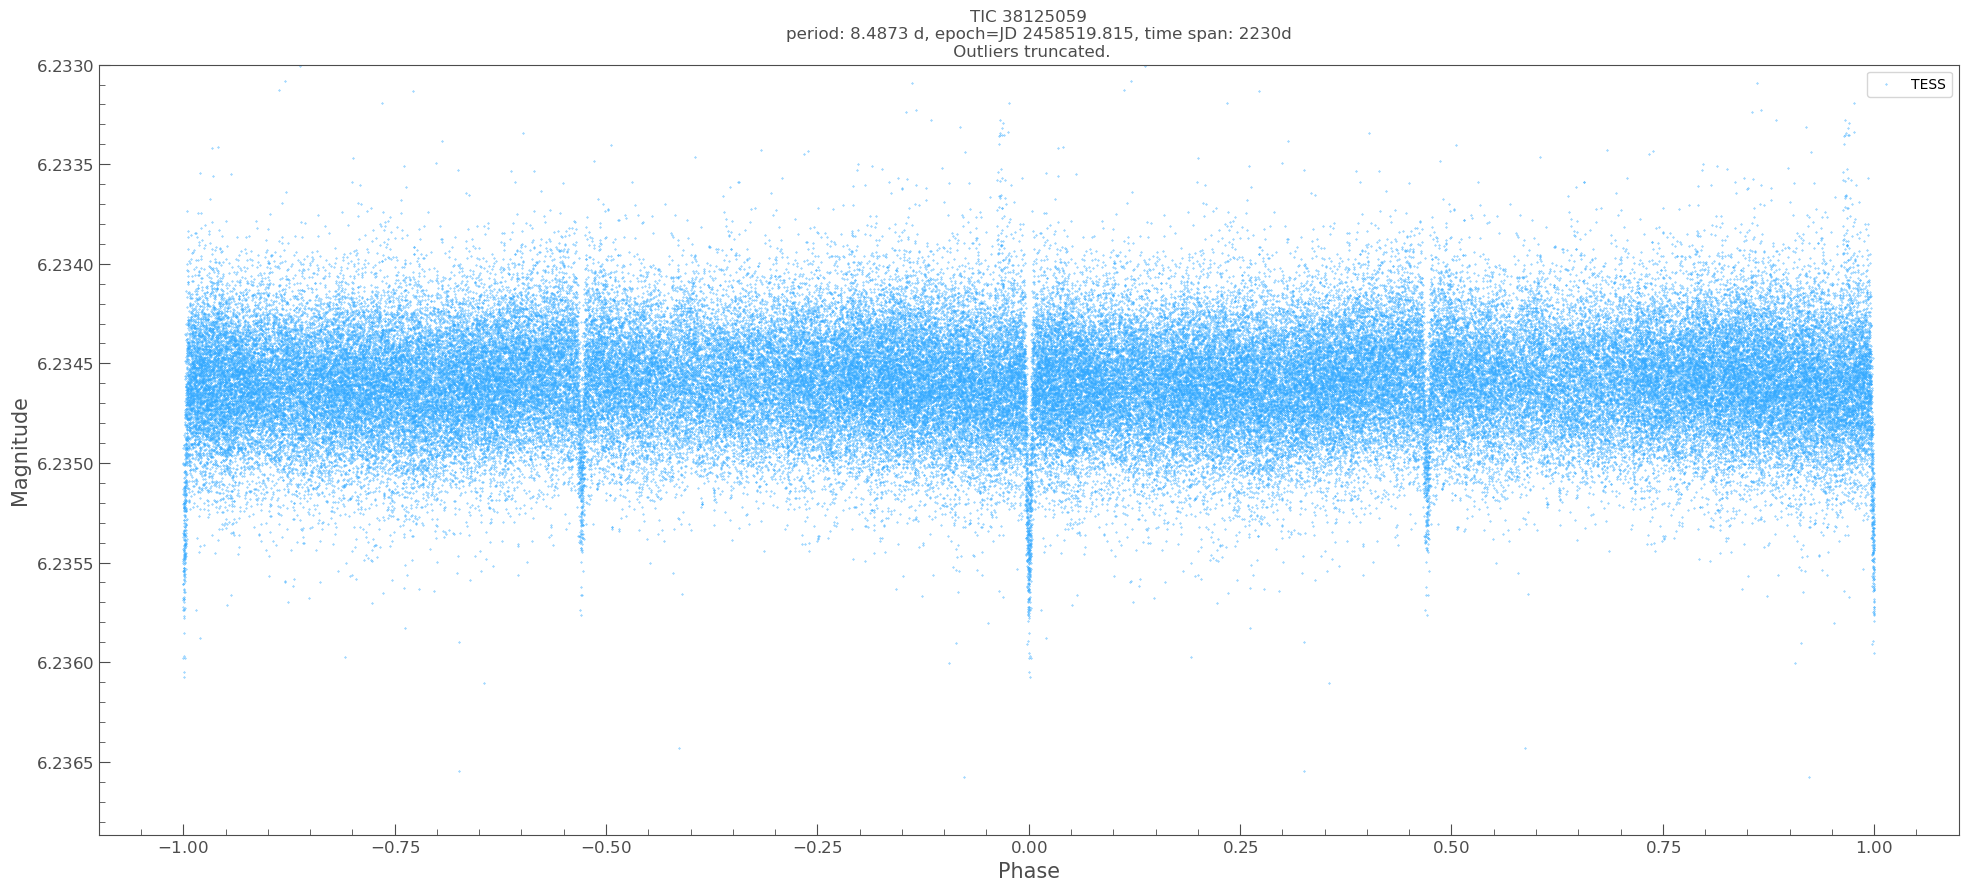

In [74]:
# reload(lkem)

plot_options = lkem.get_default_plot_multi_bands_options_copy()
# plot_options[0][1]["zorder"] = 3  # default 2
# plot_options[0][1]["s"] = 4
# plot_options[1][1]["markersize"] = 9

ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_final,
    epoch=Time(epoch_time_hjd_final , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
    figsize=(24, 10),
    target_name=primary_name,
    plot_options=plot_options,
);
ylim = (None, 6.233)
ax.set_ylim(*ylim);
ax.set_title(ax.get_title() + "\n Outliers truncated.");


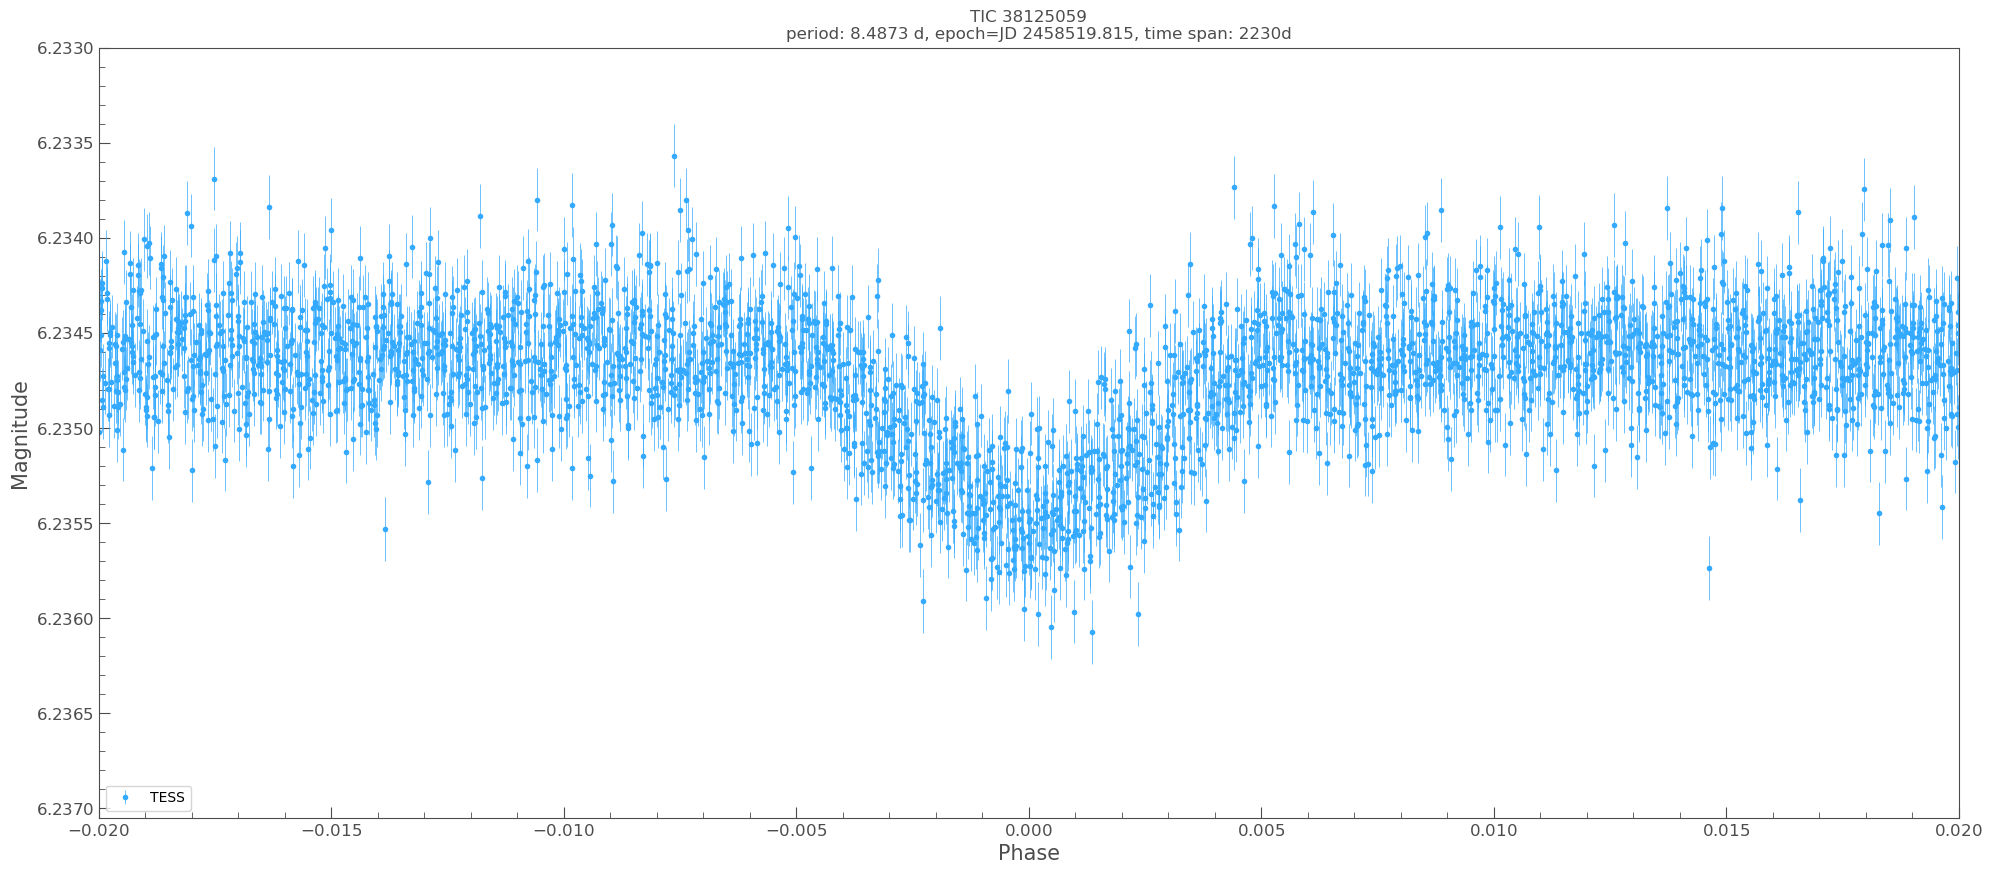

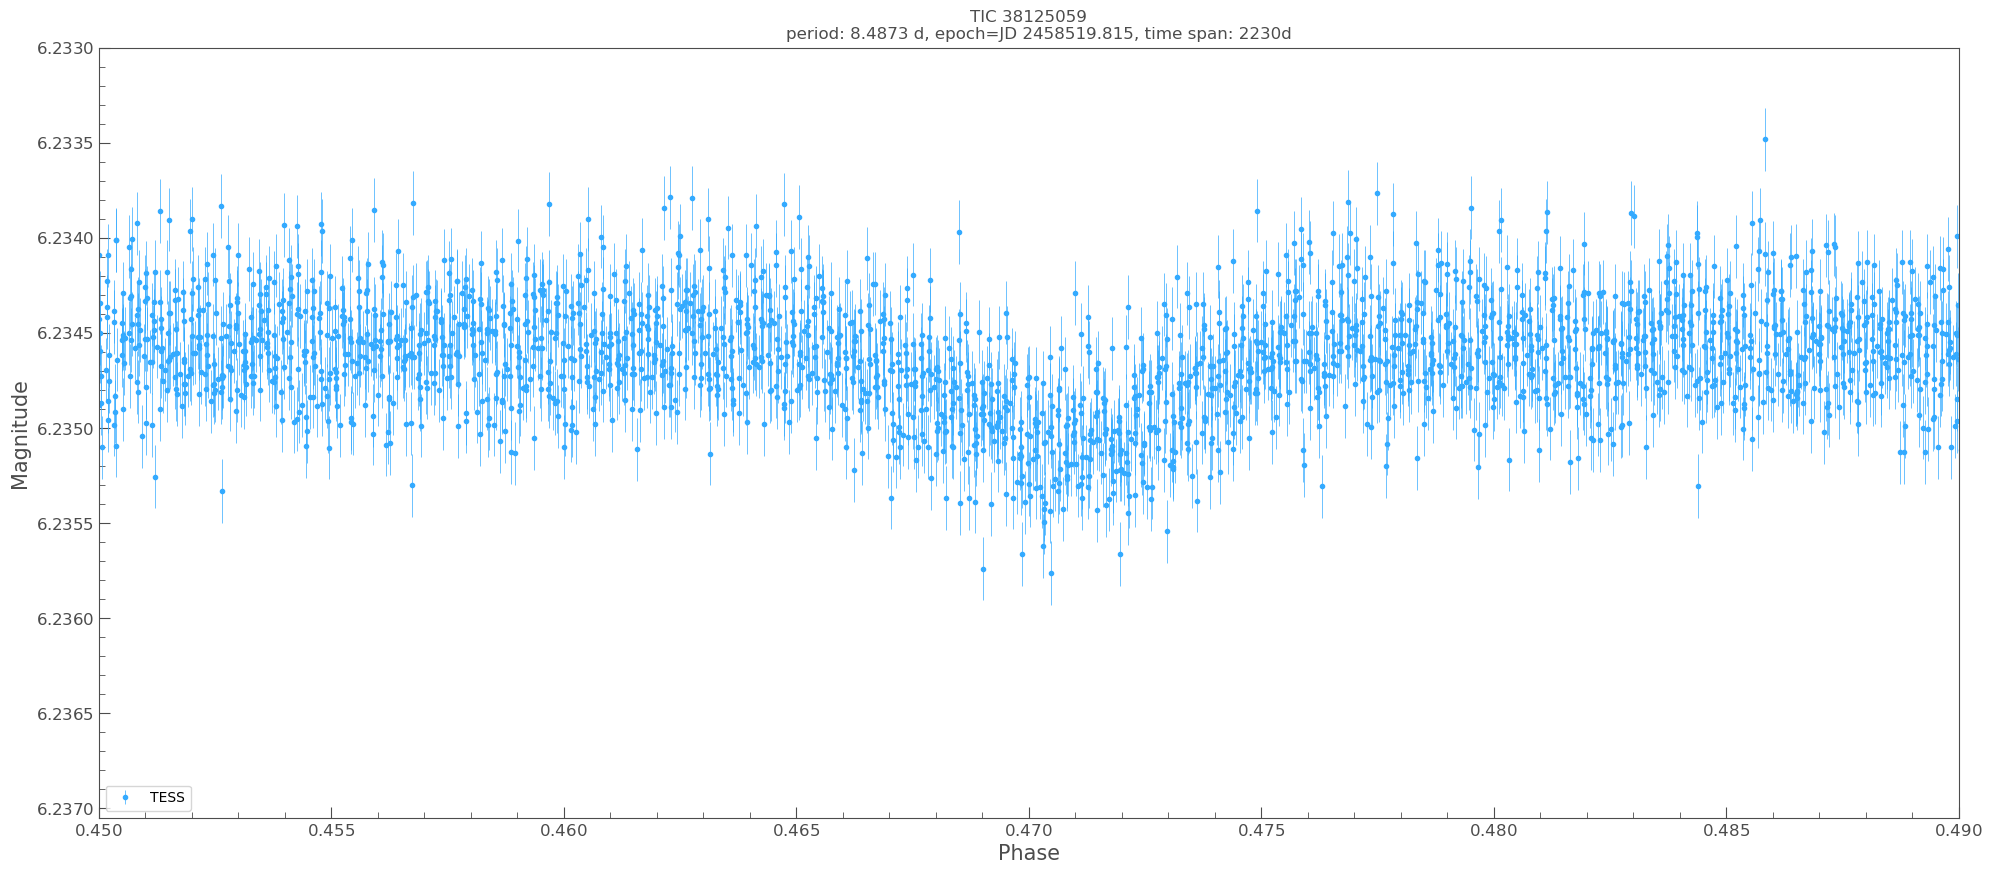

In [150]:

# zoom plot Min I
# - make TESS more visible:  larger dots
plot_options_zoom = lkem.get_default_plot_multi_bands_options_copy()
# plot_options_zoom[0][1]["s"] = 25  # larger dots
plot_options_zoom[0] = ('errorbar', {'marker': '.', 'c': '#3AF', 'linewidth': 0.5, 'ls': 'none'})  # use error bar

# to workaround astropy TypeError: cannot write to unmasked output when doing matplotlib errorbar  plot
_lc = lc_combined_dict['TESS'].copy()
_lc.flux_err = _lc.flux_err.filled(np.nan)

ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    # lc_combined_dict,
    dict(TESS=_lc), 
    period=period_final  ,
    epoch=Time(epoch_time_hjd_final   , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    # duration_hr=duration_hr_min_i_final  ,  # for plotting only
    figsize=(24, 10),
    plot_options=plot_options_zoom,
    # mag_shift_precision=2,  #
);
ax.set_ylim(*ylim);
ax.legend(loc="lower left");
# ax.axvline(0, c="gray", linestyle="dotted");
ax.set_xlim(-0.02, 0.02);  # to see primary in details


# zoom plot - Min II
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    # lc_combined_dict,
    dict(TESS=_lc), 
    period=period_final  ,
    epoch=Time(epoch_time_hjd_final   , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    # duration_hr=duration_hr_min_ii_final  ,  # for plotting only
    duration_midpoint_phase=epoch_phase_min_ii_final  ,
    plot_options=plot_options_zoom,
    figsize=(24, 10),
    # mag_shift_precision=2,  #
);
ax.set_ylim(*ylim);
ax.legend(loc="lower left");
ax.set_xlim(epoch_phase_min_ii_final  -0.02, epoch_phase_min_ii_final  +0.02);  # to see Min II in details


## VSX Report Table

In [153]:
def report_to_df(report):
    df = pd.DataFrame()
    df["Field"] = report.keys()
    df["Value"] = report.values()
    return df


def vsx_phase(phase):
    # the phase I used above is from [-0.5, +0.5]
    # convert to the phase [0, 1[ used by VSX
    if phase < -0.5 or phase > 0.5:
        raise ValueError(f"Input phase needs to be in [-0.5, 0.5] range. Actual: {phase}")
    if phase >= 0:
        return phase 
    else: 
        return 1 + phase


In [154]:
import bibs_utils
# reload(bibs_utils)

other_names = f"HIP 44874,TYC 6590-806-1,2MASS J09083663-2550219"  # ExoFOP  and  SIMBAD
other_names += ",WDS J09086-2550A,HD 78643A,GJ 9287 A,GSC 06590-00806"  # Useful IDs from SIMBAD


remarks = (
    f"""Eccentric system. Min II at phase {vsx_phase(epoch_phase_min_ii_final)}, amplitude {amp_min_ii_flux_mag} TESS, duration {100 * duration_hr_min_ii_final / 24 / period_final:.2f}% . """
    f"""Uncertain identification: Nearby TIC 830918261 / WDS J09086-2550BC (V=11.8; 2" to the N) might be the source. The two form a quadruple system per 2018ApJS..235....6T . The eclipses suggest a fifth component."""
)

revision_comment = "Type, period, epoch, eclipse duration and amplitude from TESS data. Mean magnitude derived from Gaia DR3. Position from Gaia DR3. Spectral type from 2018ApJS..235....6T ."


BIBS = bibs_utils.BIBS
vsx_report = dict(
    Position=f"{target_coord.ra.value}, {target_coord.dec.value}",
    Primary_Name=primary_name,
    Other_Names=other_names,
    Variable_Type="EA",
    Spectral_Type="G0/1V",  # from MSC
    Spectral_Type_Uncertain=False,
    Maximum_Magnitude=f"{mean_flux_v_mag:.2f}",  # from Gaia DR3
    Maximum_Magnitude_band="V",
    Minimum_Magnitude=f"{amp_flux_mag:}",   # in TESS from the plot above
    Minimum_Magnitude_band="TESS",  
    Minimum_Is_Amplitude=True,

    Period=f"{period_final}",  
    Epoch=f"{epoch_time_hjd_final:}",  
    Rise_Duration_Pct=f"{100 * duration_hr_min_i_final / 24 / period_final:.2f}",  # use 2 decimal points as it's < 1%
    Discoverer="A. Prša et al.",   # TESS_EB paper
    Remarks=remarks,
    Revision_Comment=revision_comment,
    Reference0_Name=BIBS.TESS_N,
    Reference0_Bib=BIBS.TESS_B,
    Reference1_Name=BIBS.TESSEB_N,  # for initial variable discovery
    Reference1_Bib=BIBS.TESSEB_B,  
    Reference2_Name=BIBS.GAIA_DR3_N,  # for mean V mag
    Reference2_Bib=BIBS.GAIA_DR3_B,  
    Reference3_Name="Tokovinin, Andrei, 2018, The Updated Multiple Star Catalog",  # multi star system, and spectral type
    Reference3_Bib="2018ApJS..235....6T",  
)

def print_long_fields(report):
    other_names_list = report["Other_Names"].split(",")
    print("Other Names (1 line each):")
    print("\n".join(other_names_list))
    print("")
    print(report["Remarks"])
    print("")
    print(report["Revision_Comment"])

print_long_fields(vsx_report)
with pd.option_context('display.max_colwidth', None):
    display(report_to_df(vsx_report))


# Combined LC probably not needed for EA with no long term variation
# tic61768908_combined_plot.png : Combined light curve - Combined light curve from from TESS and corrected ASAS-SN; shifted to corrected ASAS-SN V.
print("""
tic38125059_phase_plot_eclipses.png : EA Phase Plot - EA Phase Plot from TESS data
tic38125059_phase_plot_eclipses_min_i.png : EA Phase Plot (Min I zoom) - EA Phase Plot, zoomed to Min I.
tic38125059_phase_plot_eclipses_min_ii.png : EA Phase Plot (Min II zoom) - EA Phase Plot, zoomed to Min II.
""")


Other Names (1 line each):
HIP 44874
TYC 6590-806-1
2MASS J09083663-2550219
WDS J09086-2550A
HD 78643A
GJ 9287 A
GSC 06590-00806

Eccentric system. Min II at phase 0.47, amplitude 0.0005 TESS, duration 0.88% . Uncertain identification: Nearby TIC 830918261 / WDS J09086-2550BC (V=11.80; 2" to the N) might be the source. The two form a quadruple system per 2018ApJS..235....6T . The eclipses suggest a fifth component.

Type, period, epoch, eclipse duration and amplitude from TESS data. Mean magnitude derived from Gaia DR3. Position from Gaia DR3. Spectral type from 2018ApJS..235....6T .


,Field,Value
0,Position,"137.15254570936, -25.83949586418"
1,Primary_Name,TIC 38125059
2,Other_Names,"HIP 44874,TYC 6590-806-1,2MASS J09083663-2550219,WDS J09086-2550A,HD 78643A,GJ 9287 A,GSC 06590-00806"
3,Variable_Type,EA
4,Spectral_Type,G0/1V
5,Spectral_Type_Uncertain,False
6,Maximum_Magnitude,6.77
7,Maximum_Magnitude_band,V
8,Minimum_Magnitude,0.001
9,Minimum_Magnitude_band,TESS



tic38125059_phase_plot_eclipses.png : EA Phase Plot - EA Phase Plot from TESS data
tic38125059_phase_plot_eclipses_min_i.png : EA Phase Plot (Min I zoom) - EA Phase Plot, zoomed to Min I.
tic38125059_phase_plot_eclipses_min_ii.png : EA Phase Plot (Min II zoom) - EA Phase Plot, zoomed to Min II.

